In [1]:
# https://catalog.data.gov/dataset/accidental-drug-related-deaths-january-2012-sept-2015

In [29]:
from pathlib import Path
import pandas as pd
from scipy.stats import norm, powerlaw
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import xgboost as xgb

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [30]:
print("Directory Path:", Path().absolute())

Directory Path: /Users/changlonghuang/Python/Scripts


In [31]:
raw_data = pd.read_csv("/Users/changlonghuang/Python/Data/allegheny_county_property_sale_transactions.csv")

/Users/changlonghuang/.pyenv/versions/3.8.5/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Before doing any market analysis on property sales, check the sales validation codes.
Many property "sales" are not considered a valid representation of the true market value of the property.
For example, when multiple lots are together on one deed with one price they are generally coded as invalid ("H")
because the sale price for each parcel ID number indicates the total price paid for a group of parcels,
not just for one parcel.
See the Sales Validation Codes Dictionary for a complete explanation of valid and invalid sale codes.

In [32]:
# cleaning up the data
raw_data.head()

,PARID,PROPERTYHOUSENUM,PROPERTYFRACTION,PROPERTYADDRESSDIR,PROPERTYADDRESSSTREET,PROPERTYADDRESSSUF,PROPERTYADDRESSUNITDESC,PROPERTYUNITNO,PROPERTYCITY,PROPERTYSTATE,...,MUNIDESC,RECORDDATE,SALEDATE,PRICE,DEEDBOOK,DEEDPAGE,SALECODE,SALEDESC,INSTRTYP,INSTRTYPDESC
0,1075F00108000000,4720.0,,NaN,HIGHPOINT,DR,NaN,NaN,GIBSONIA,PA,...,Hampton,2012-09-27,2012-09-27,120000.0,15020,356,3,LOVE AND AFFECTION SALE,DE,DEED
1,0011A00237000000,0.0,,NaN,LOMBARD,ST,NaN,NaN,PITTSBURGH,PA,...,3rd Ward - PITTSBURGH,2015-01-06,2015-01-06,1783.0,TR15,2,2,CITY TREASURER SALE,TS,TREASURER DEED
2,0011J00047000000,1903.0,,NaN,FORBES,AVE,NaN,NaN,PITTSBURGH,PA,...,1st Ward - PITTSBURGH,2012-10-26,2012-10-26,4643.0,TR13,3,2,CITY TREASURER SALE,TS,TREASURER DEED
3,0113B00029000000,479.0,,NaN,ROOSEVELT,AVE,NaN,NaN,PITTSBURGH,PA,...,Bellevue,2017-03-27,2017-03-06,0.0,16739,166,3,LOVE AND AFFECTION SALE,CO,CORRECTIVE DEED
4,0119S00024000000,5418.0,,NaN,CARNEGIE,ST,NaN,NaN,PITTSBURGH,PA,...,10th Ward - PITTSBURGH,2015-02-04,2015-02-04,27541.0,TR15,59,GV,GOVERNMENT SALE,TS,TREASURER DEED


In [33]:
raw_data.dtypes

PARID                       object
PROPERTYHOUSENUM           float64
PROPERTYFRACTION            object
PROPERTYADDRESSDIR          object
PROPERTYADDRESSSTREET       object
PROPERTYADDRESSSUF          object
PROPERTYADDRESSUNITDESC     object
PROPERTYUNITNO              object
PROPERTYCITY                object
PROPERTYSTATE               object
PROPERTYZIP                float64
SCHOOLCODE                   int64
SCHOOLDESC                  object
MUNICODE                     int64
MUNIDESC                    object
RECORDDATE                  object
SALEDATE                    object
PRICE                      float64
DEEDBOOK                    object
DEEDPAGE                    object
SALECODE                    object
SALEDESC                    object
INSTRTYP                    object
INSTRTYPDESC                object
dtype: object

In [34]:
raw_data.describe()
date_col = ["SALEDATE","RECORDDATE"]
cat_var = ["PROPERTYCITY", "INSTRTYP"]
prefix_val = ["CITY", "INSTRTYPE"]
col_for_ml = ["PROPERTYCITY","SALEDATE","RECORDDATE","INSTRTYP","PROPERTYZIP","SCHOOLCODE"]
predictive_col = ["PRICE"]
all_col = col_for_ml + predictive_col

def clean_dates(df, input_date_col):
    new_col_name = "CLEAN_" + input_date_col
    new_year_col_name = input_date_col + "_YEAR"
    new_month_col_name = input_date_col + "_MONTH"
    
    df[new_col_name] = pd.to_datetime(df[input_date_col],infer_datetime_format = True, errors = 'coerce')
    df[new_year_col_name] = df[new_col_name].dt.year.fillna(0).astype(int)
    df[new_month_col_name] = df[new_col_name].dt.month.fillna(0).astype(int)
    df.drop(columns = new_col_name)
    return df, new_year_col_name, new_month_col_name

for i in date_col:
    clean_date_df, ny_col_name, nm_col_name  = clean_dates(raw_data, i)
    col_for_ml.append(ny_col_name)
    col_for_ml.append(nm_col_name)
clean_date_df.head()

,PARID,PROPERTYHOUSENUM,PROPERTYFRACTION,PROPERTYADDRESSDIR,PROPERTYADDRESSSTREET,PROPERTYADDRESSSUF,PROPERTYADDRESSUNITDESC,PROPERTYUNITNO,PROPERTYCITY,PROPERTYSTATE,...,SALECODE,SALEDESC,INSTRTYP,INSTRTYPDESC,CLEAN_SALEDATE,SALEDATE_YEAR,SALEDATE_MONTH,CLEAN_RECORDDATE,RECORDDATE_YEAR,RECORDDATE_MONTH
0,1075F00108000000,4720.0,,NaN,HIGHPOINT,DR,NaN,NaN,GIBSONIA,PA,...,3,LOVE AND AFFECTION SALE,DE,DEED,2012-09-27,2012,9,2012-09-27,2012,9
1,0011A00237000000,0.0,,NaN,LOMBARD,ST,NaN,NaN,PITTSBURGH,PA,...,2,CITY TREASURER SALE,TS,TREASURER DEED,2015-01-06,2015,1,2015-01-06,2015,1
2,0011J00047000000,1903.0,,NaN,FORBES,AVE,NaN,NaN,PITTSBURGH,PA,...,2,CITY TREASURER SALE,TS,TREASURER DEED,2012-10-26,2012,10,2012-10-26,2012,10
3,0113B00029000000,479.0,,NaN,ROOSEVELT,AVE,NaN,NaN,PITTSBURGH,PA,...,3,LOVE AND AFFECTION SALE,CO,CORRECTIVE DEED,2017-03-06,2017,3,2017-03-27,2017,3
4,0119S00024000000,5418.0,,NaN,CARNEGIE,ST,NaN,NaN,PITTSBURGH,PA,...,GV,GOVERNMENT SALE,TS,TREASURER DEED,2015-02-04,2015,2,2015-02-04,2015,2


In [35]:
sales_mean_df = clean_date_df.groupby("SALEDATE_YEAR")["PRICE"].mean()

clean_date_df["PRICE"].describe()
no_price_outlier_df = clean_date_df[clean_date_df["PRICE"] < 250000]


(mu, sigma) = norm.fit(no_price_outlier_df['PRICE'])
print( 'mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
print("Skewness: %f" % no_price_outlier_df['PRICE'].skew())
print("Kurtosis: %f" % no_price_outlier_df['PRICE'].kurt())

mu = 67810.52 and sigma = 73698.74

Skewness: 0.754731
Kurtosis: -0.722471


In [36]:
# Mostly deeds and primarily sold in 2012 - 2016 basically the aftermath of the 2008
# no_price_outlier_df[no_price_outlier_df["PRICE"] < 5000].groupby("SALEDATE_YEAR").size()

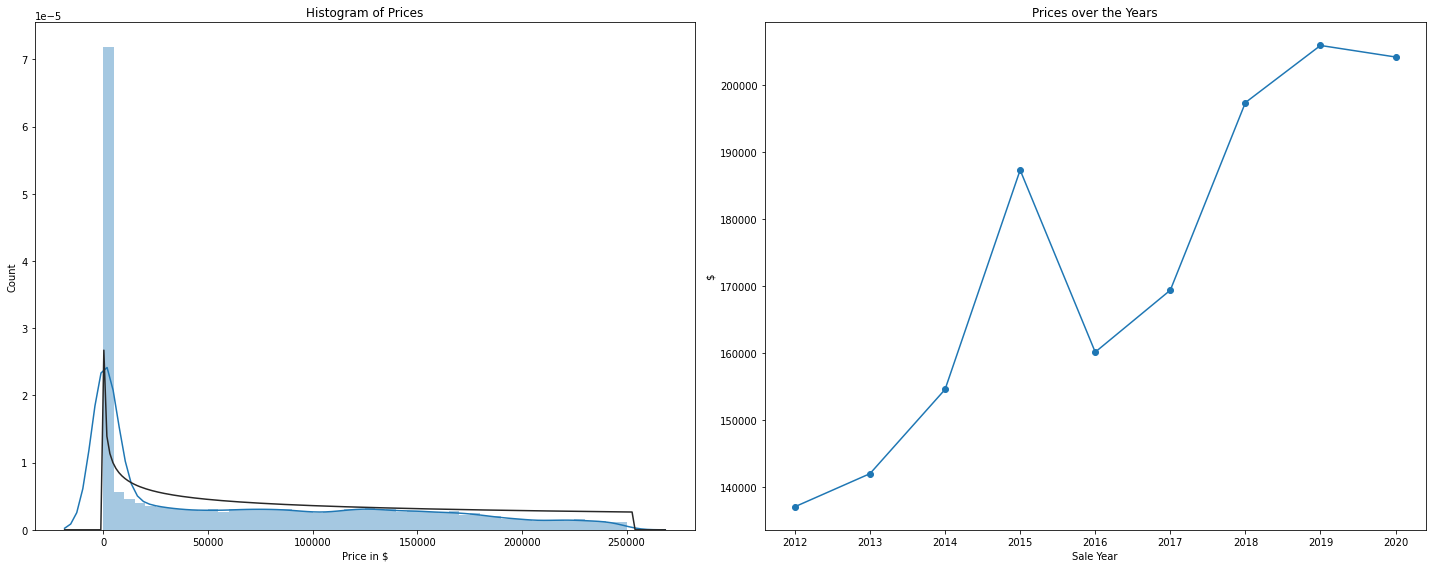

In [37]:
fig, axes = plt.subplots(1,2, figsize = (20,8))

# From this chart we can see that the prices for most property follows the powerlaw and are dirt cheap. <$25,000
# I suspect that these types of properties are not residential
sns.distplot(no_price_outlier_df["PRICE"],fit = powerlaw, ax = axes[0])
axes[0].set_xlabel("Price in $")
axes[0].set_ylabel("Count")
axes[0].set_title("Histogram of Prices")


axes[1].plot(sales_mean_df, marker = "o")
axes[1].set_xlabel("Sale Year")
axes[1].set_ylabel("$")
axes[1].set_title("Prices over the Years")

plt.tight_layout()
plt.show()

In [38]:
# look at the counts and nulls for each column
# clean up the current columns in dataset for machine learning
# only strip the strings for the string type columns
clean_df = clean_date_df[all_col]

for i in col_for_ml:
    num_total = clean_date_df.groupby(i).size().count()
    num_null = clean_date_df[i].isna().sum()
    col_series = clean_date_df.groupby(i).size().sort_values(ascending = False).reset_index()
    print("Num of unique values for: " + i + " is " + num_total.astype(str))
    print("Num of null values is " + num_null.astype(str))
    if type(col_series[i].iloc[0]) == str:
        clean_df[i] = clean_df[i].str.strip()
        print("Most common value " + col_series[i].iloc[0] + " has count: " + col_series[0].iloc[0].astype(str))
    else:
        print("Most common value " + col_series[i].iloc[0].astype(str) + " has count: " + col_series[0].iloc[0].astype(str))
                 
    if num_null > 0:
        clean_df[i].fillna(value = col_series[0].iloc[0],inplace = True)
    else:
        pass
    print()

Num of unique values for: PROPERTYCITY is 98
Num of null values is 1
Most common value PITTSBURGH has count: 159279

Num of unique values for: SALEDATE is 2918
Num of null values is 0


<ipython-input-38-8e400523ab00>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df[i] = clean_df[i].str.strip()
/Users/changlonghuang/.pyenv/versions/3.8.5/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Most common value 2016-04-29 has count: 597

Num of unique values for: RECORDDATE is 2300
Num of null values is 1226
Most common value 2012-10-26 has count: 594

Num of unique values for: INSTRTYP is 28
Num of null values is 0
Most common value DE has count: 167518

Num of unique values for: PROPERTYZIP is 118
Num of null values is 1
Most common value 15108.0 has count: 10234

Num of unique values for: SCHOOLCODE is 46
Num of null values is 0
Most common value 47 has count: 73193

Num of unique values for: SALEDATE_YEAR is 9
Num of null values is 0
Most common value 2018 has count: 36631

Num of unique values for: SALEDATE_MONTH is 12
Num of null values is 0
Most common value 6 has count: 28898

Num of unique values for: RECORDDATE_YEAR is 14
Num of null values is 0
Most common value 2018 has count: 36727

Num of unique values for: RECORDDATE_MONTH is 13
Num of null values is 0
Most common value 6 has count: 28491



In [45]:
clean_df.loc[clean_df['PROPERTYCITY'] == 159279]

clean_df.loc[clean_df['PROPERTYCITY'] == 159279, "PRICE"] = 159279
clean_df.loc[clean_df['PROPERTYCITY'] == 159279, "PROPERTYCITY"] = "PITTSBURGH"

clean_df.drop(labels = ["SALEDATE","RECORDDATE"],axis = 1,inplace = True)

/Users/changlonghuang/.pyenv/versions/3.8.5/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/changlonghuang/.pyenv/versions/3.8.5/lib/python3.8/site-packages/pandas/core/frame.py:4157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [46]:
ml_df = pd.get_dummies(data = clean_df, prefix = prefix_val, columns  = cat_var)

In [47]:
#ml_df.columns.tolist()

In [48]:
def split_out_col(df, col):
    return df.drop(labels = col, axis = 1),df[col]

In [52]:
seed = 42
x_train, x_test = train_test_split(ml_df,test_size=0.33, random_state=seed)

(train_x, train_y) = split_out_col(x_train, predictive_col)
(test_x, test_y) = split_out_col(x_test, predictive_col)

In [67]:
# doesn't work right now
model = xgb.XGBRegressor(booster ='gblinear')
model.fit(train_x,train_y)
print (model)
prediction_x = model.predict(test_x)
prediction_x

XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.5, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=None, random_state=0,
             reg_alpha=0, reg_lambda=0, scale_pos_weight=1, subsample=None,
             tree_method=None, validate_parameters=1, verbosity=None)


array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)